In [1]:
# Import the necessary libraries for reading and working with the data
import numpy as np
import pandas as pd

# Import the libraries for visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# Import the preprocessing steps
from sklearn.preprocessing import StandardScaler

# Import RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier

# Import roc_auc_score
from sklearn.metrics import roc_auc_score

# Import train_test_split
from sklearn.model_selection import train_test_split

%matplotlib inline

In [2]:
# Read the two csv files

# Import the user engagements
user_engagements = pd.read_csv('takehome_user_engagement.csv')

# Import the user data
users = pd.read_csv('takehome_users.csv', encoding='latin-1')

There was some original difficulty loading in the users data as encoding utf-8 could not process parts of the data. As a result, I used latin-1 as recommended on stackoverflow: https://stackoverflow.com/questions/35290039/unicodedecodeerror-ascii-codec-cant-decode-byte-0xe6-in-position-1206-ordin

In [3]:
# Print the head of the users dataframe
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,4/22/2014 3:53,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,11/15/2013 3:45,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,3/19/2013 23:14,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,5/21/2013 8:09,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,1/17/2013 10:14,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [4]:
# Print the head of the user engagement dataframe
user_engagements.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


### Problem

Defining an "adopted user" as a user who has logged into the product on three separate days in at least one seven-day period, identify which factors predict future user adoption.

We suggest spending 1-2 hours on this, but you're welcome to spend more or less. Please send us a brief writeup of your findings (the more concise, the better no more than one page), along with any summary tables, graphs, code, or queries that can help
us understand your approach. Please note any factors you considered or investigation you did, even if they did not pan out. Feel free to identify any further research or data you think would be valuable.

To start this problem, I'll start by creating the target column adopted_user. The adopted_user will be any user that has logged into the product on three separate days within a 7 day period.

To resample the data, I need to first resample to daily and add a column for each day a login occured. I have to add this column because it is possible that a user logs in more than once per day. From there, I would resample to weekly and add up the total daily logins. 

However, before I do all of that, I need to convert the time_stamp column to a datetime object for resampling. Additionally, I groupby the user IDs to ensure that the resampling doesn't affect it.

The purpose of the user engagements dataframe is to define a column of user ids that are adopted users. The rest of the time_stamp information can be scrapped. 

In [5]:
user_engagements['time_stamp'].head()

0    2014-04-22 03:53:30
1    2013-11-15 03:45:04
2    2013-11-29 03:45:04
3    2013-12-09 03:45:04
4    2013-12-25 03:45:04
Name: time_stamp, dtype: object

In [6]:
# Convert the time_stamp column to dtype datetime
user_engagements['time_stamp'] = pd.to_datetime(user_engagements['time_stamp'])

In [7]:
# Resample the data to daily
daily_users = user_engagements.groupby('user_id').resample('1D', on='time_stamp').sum().drop('user_id', axis=1)

In [8]:
# Reset the index
daily_users.reset_index(inplace=True)

In [9]:
# Remove all the invalid entries that were made during resampling
daily_users = daily_users[daily_users['visited'] != 0]

# Create a column for daily visits
daily_users['daily_visits'] = 1

In [10]:
# Resample the data to weekly
weekly_users = daily_users.groupby('user_id').resample('1W', on='time_stamp').sum().drop('user_id', axis=1)

In [11]:
weekly_users = weekly_users[weekly_users['visited'] != 0]

In [12]:
weekly_users['adopted_user'] = weekly_users['daily_visits'].apply(lambda x: 1 if x >= 3 else 0)

In [13]:
# Check if the visited and daily_visits columns are equivalent
weekly_users['visited'].equals(weekly_users['daily_visits'])

True

In [14]:
weekly_users.head()

visited  daily_visits  adopted_user
user_id time_stamp                                     
1       2014-04-27        1             1             0
2       2013-11-17        1             1             0
        2013-12-01        1             1             0
        2013-12-15        1             1             0
        2013-12-29        1             1             0

Group by the user ids to perpare it for merging. I will take the sum of the remaining columns and change the adopted_user column back to a binary variable.

In [15]:
# Reset the index
weekly_users.reset_index(inplace=True)

# Group by the data and take the sum of daily_visits and adopted_user
grouped_users = weekly_users.groupby('user_id').agg({'daily_visits': 'sum', 'adopted_user': 'sum'}).reset_index()

In [16]:
# Turn the adoped_user to a binary column
grouped_users['adopted_user'] = grouped_users['adopted_user'].apply(lambda x: 1 if x > 0 else 0)

In [17]:
grouped_users.head()

,user_id,daily_visits,adopted_user
0,1,1,0
1,2,14,1
2,3,1,0
3,4,1,0
4,5,1,0


In [18]:
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,4/22/2014 3:53,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,11/15/2013 3:45,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,3/19/2013 23:14,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,5/21/2013 8:09,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,1/17/2013 10:14,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [19]:
# Sanity check to make sure no user ids were lost
assert grouped_users['user_id'].nunique() == user_engagements['user_id'].nunique()

In [20]:
# Print the number of user ids in each dataset
print (users['object_id'].nunique())
print (grouped_users['user_id'].nunique())

12000
8823


Since the users dataset has more unique user ids than the user engagement datasets, I will perform a left merge to retain all the rows in the main dataset. From there, I will fill in the null values from the merge with 0's to represent that the user has no login activity.

Before I perform the merge, I will convert the last_session_creation_time from a unix timestamp to a human readable format. I will also conver the creation_time column to a datetime object.

In [21]:
# Convert the last_session_creation_time to datetime object
users['last_session_creation_time'] = pd.to_datetime(users['last_session_creation_time'], unit='s')

# Convert the creation_time to datetime object
users['creation_time'] = pd.to_datetime(users['creation_time'])

In [22]:
# Merge the user engagement data with user data
merged_users = users.merge(grouped_users, how='left', left_on='object_id', right_on='user_id')

# Drop the user_id column
merged_users.drop('user_id', axis=1, inplace=True)

In [23]:
# Check for null values in the merged dataframe
merged_users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 0 to 11999
Data columns (total 12 columns):
object_id                     12000 non-null int64
creation_time                 12000 non-null datetime64[ns]
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    8823 non-null datetime64[ns]
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
daily_visits                  8823 non-null float64
adopted_user                  8823 non-null float64
dtypes: datetime64[ns](2), float64(3), int64(4), object(3)
memory usage: 1.2+ MB


It appears that there are last_session_creation_time and invited_by_user_id columns. These are not from the user engagements dataframe so it would not appropriate to fill the nul lvalues here similarly. Let's explore these null values first.

In [24]:
merged_users[merged_users['last_session_creation_time'].isnull()].head(10)

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,daily_visits,adopted_user
7,8,2013-07-31 05:34:00,Hamilton Danielle,DanielleHamilton@yahoo.com,PERSONAL_PROJECTS,NaT,1,1,74,NaN,NaN,NaN
8,9,2013-11-05 04:04:00,Amsel Paul,PaulAmsel@hotmail.com,PERSONAL_PROJECTS,NaT,0,0,302,NaN,NaN,NaN
11,12,2014-04-17 23:48:00,Mathiesen Lærke,LaerkeLMathiesen@cuvox.de,ORG_INVITE,NaT,0,0,130,9270.0,NaN,NaN
14,15,2013-07-16 21:33:00,Theiss Ralf,RalfTheiss@hotmail.com,PERSONAL_PROJECTS,NaT,0,0,175,NaN,NaN,NaN
15,16,2013-02-11 10:09:00,Engel René,ReneEngel@hotmail.com,PERSONAL_PROJECTS,NaT,0,0,211,NaN,NaN,NaN
17,18,2013-08-24 00:26:00,Gregersen Celina,CelinaAGregersen@jourrapide.com,GUEST_INVITE,NaT,0,0,2,3153.0,NaN,NaN
25,26,2013-07-28 00:53:00,Wexler Florian,FlorianWexler@jourrapide.com,ORG_INVITE,NaT,0,0,56,11857.0,NaN,NaN
31,32,2013-04-17 16:21:00,Perez Timothy,TimothyJPerez@yahoo.com,PERSONAL_PROJECTS,NaT,1,1,98,NaN,NaN,NaN
33,34,2014-02-03 20:55:00,Holm Sara,SaraMHolm@hotmail.com,ORG_INVITE,NaT,0,0,33,3721.0,NaN,NaN
34,35,2013-08-01 10:55:00,Krueger Dieter,DieterKrueger@gustr.com,PERSONAL_PROJECTS,NaT,0,0,59,NaN,NaN,NaN


In [25]:
merged_users[merged_users['invited_by_user_id'].isnull()].head(10)

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,daily_visits,adopted_user
6,7,2012-12-16 13:24:00,Sewell Tyler,TylerSewell@jourrapide.com,SIGNUP,2012-12-20 13:24:32,0,1,37,NaN,1.0,0.0
7,8,2013-07-31 05:34:00,Hamilton Danielle,DanielleHamilton@yahoo.com,PERSONAL_PROJECTS,NaT,1,1,74,NaN,NaN,NaN
8,9,2013-11-05 04:04:00,Amsel Paul,PaulAmsel@hotmail.com,PERSONAL_PROJECTS,NaT,0,0,302,NaN,NaN,NaN
10,11,2013-12-26 03:55:00,Paulsen Malthe,MaltheAPaulsen@gustr.com,SIGNUP,2013-12-27 03:55:54,0,0,69,NaN,1.0,0.0
13,14,2012-10-11 16:14:00,Rivera Bret,BretKRivera@gmail.com,SIGNUP,2012-10-12 16:14:33,0,0,0,NaN,1.0,0.0
14,15,2013-07-16 21:33:00,Theiss Ralf,RalfTheiss@hotmail.com,PERSONAL_PROJECTS,NaT,0,0,175,NaN,NaN,NaN
15,16,2013-02-11 10:09:00,Engel René,ReneEngel@hotmail.com,PERSONAL_PROJECTS,NaT,0,0,211,NaN,NaN,NaN
18,19,2013-05-24 14:56:00,Collins Arlene,ArleneRCollins@gmail.com,SIGNUP,2013-05-30 14:56:36,1,0,0,NaN,2.0,0.0
19,20,2014-03-06 11:46:00,Helms Mikayla,lqyvjilf@uhzdq.com,SIGNUP,2014-05-29 11:46:38,0,0,58,NaN,7.0,1.0
20,21,2013-01-22 12:27:00,Hunter Alfie,AlfieHunter@gmail.com,PERSONAL_PROJECTS,2013-01-22 12:27:42,0,0,54,NaN,1.0,0.0


In [26]:
merged_users['invited_by_user_id'].describe()

count     6417.000000
mean      5962.957145
std       3383.761968
min          3.000000
25%       3058.000000
50%       5954.000000
75%       8817.000000
max      11999.000000
Name: invited_by_user_id, dtype: float64

It appears that last_session_creation_time indicates when the user last logged in. However, if the user has never logged in, then this variable would be null. This makes sense as there is an equal number null values in this variable to the nulls from the merge (nulls in both cases indicate no previous logins). As a result, I will fill this column with their creation times.

For the null values in invited_by_user_id, they likely represent joining with no external invitations. For this column, I will fill the null values with 0's

In [27]:
# Fill the null values in last_session_creation_time
merged_users['last_session_creation_time'].fillna(merged_users['creation_time'], inplace=True)

# Fill the null values in invited_by_user_id
merged_users['invited_by_user_id'].fillna(0, inplace=True)

In [28]:
# Now fill the null values from merging (all with 0's)
merged_users['daily_visits'].fillna(0, inplace=True)

merged_users['adopted_user'].fillna(0, inplace=True)

In [29]:
# Check for null values
merged_users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 0 to 11999
Data columns (total 12 columns):
object_id                     12000 non-null int64
creation_time                 12000 non-null datetime64[ns]
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    12000 non-null datetime64[ns]
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            12000 non-null float64
daily_visits                  12000 non-null float64
adopted_user                  12000 non-null float64
dtypes: datetime64[ns](2), float64(3), int64(4), object(3)
memory usage: 1.2+ MB


There are some mixed dtypes in the data so I'll address that before doing some EDA.

Namely invited_by_user_id and adopted_user should be int64. The only numerical column in this data set is the daily_visits.

In [30]:
# Convert the datatypes
merged_users['invited_by_user_id'] = merged_users['invited_by_user_id'].astype('int')

merged_users['adopted_user'] = merged_users['adopted_user'].astype('int')

Let's perform EDA on the binary and numerical columns.

In [31]:
# Create a list of binary columns
BINARY = ['opted_in_to_mailing_list', 'enabled_for_marketing_drip']

# Assign the numerical column to a variable
NUMERICAL = 'daily_visits'

BINARY.append(NUMERICAL)

In [32]:
# Split the dataframe into target and non-target
target = merged_users[merged_users['adopted_user'] == 1]
non_target = merged_users[merged_users['adopted_user'] == 0]

(array([1.1166e+04, 2.6100e+02, 1.6300e+02, 1.1200e+02, 9.2000e+01,
        8.0000e+01, 5.3000e+01, 4.2000e+01, 2.2000e+01, 9.0000e+00]),
 array([  0. ,  60.6, 121.2, 181.8, 242.4, 303. , 363.6, 424.2, 484.8,
        545.4, 606. ]),
 <a list of 10 Patch objects>)

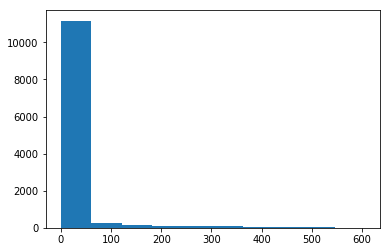

In [33]:
# Check distribution for numerical data
plt.hist(merged_users[NUMERICAL])

In [34]:
print (len(target), len(non_target))

1445 10555


The data in daily_visits has a very strong right skew. I won't address this now, but I willscale it down with StandardScaler later.

Additionally, this dataset is a very unbalanced dataset (12% target, 88% non-target).

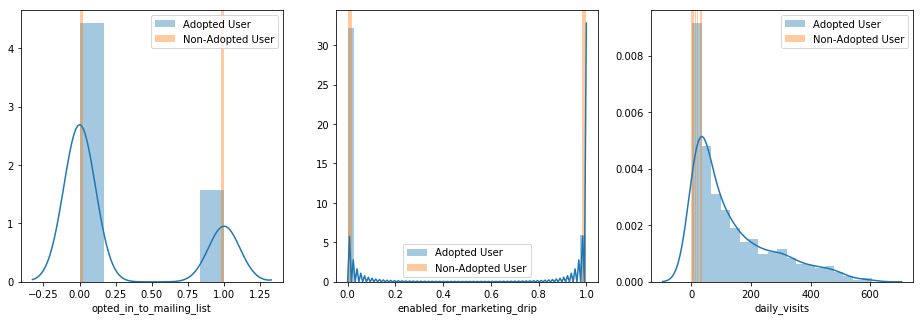

In [35]:
fig, ax = plt.subplots(ncols=3, figsize=(16,5))

for i in range(3):
    sns.distplot(target[BINARY[i]], ax=ax[i], label='Adopted User').legend()
    sns.distplot(non_target[BINARY[i]], ax=ax[i], label='Non-Adopted User', kde=False).legend()

There doesn't appear to be any real difference between the two groupings (besides daily_visits, but that's is mandatory). As a result, I'll focus on generating some more features using daily visits.

In [36]:
merged_users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,daily_visits,adopted_user
0,1,2014-04-22 03:53:00,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803,1.0,0
1,2,2013-11-15 03:45:00,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316,14.0,1
2,3,2013-03-19 23:14:00,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525,1.0,0
3,4,2013-05-21 08:09:00,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151,1.0,0
4,5,2013-01-17 10:14:00,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240,1.0,0


In [37]:
# Create a column for creation_to_active
merged_users['creation_to_active'] = (merged_users['last_session_creation_time'] - merged_users['creation_time']).dt.days + 1

# Create a column for login_perc
merged_users['login_perc'] = merged_users['daily_visits'] / merged_users['creation_to_active']

In [38]:
# Create a column for email domain
merged_users['email_domain'] = merged_users['email'].apply(lambda x: x.split('@')[-1])

In [39]:
merged_users[merged_users['creation_to_active'] == 1].shape

(6204, 15)

In [40]:
merged_users['email_domain'].nunique()

1184

From here, let's drop a couple of the columns since they're redundant or provide no additional information.

Name: unnecessary as object_id is a unique identifier
email: same reason as name, but I extracted the domain of the email
creation_time and last_session_creation_time: doesn't show up in the model. I can't use them too well because I don't know the date the information started and finished being gathered.

In [41]:
# # Drop the unnecessary columns
merged_users.drop(['creation_time', 'name', 'email', 'last_session_creation_time'], axis=1, inplace=True)

In [42]:
# Split the dataframe into target and non-target
target = merged_users[merged_users['adopted_user'] == 1]
non_target = merged_users[merged_users['adopted_user'] == 0]

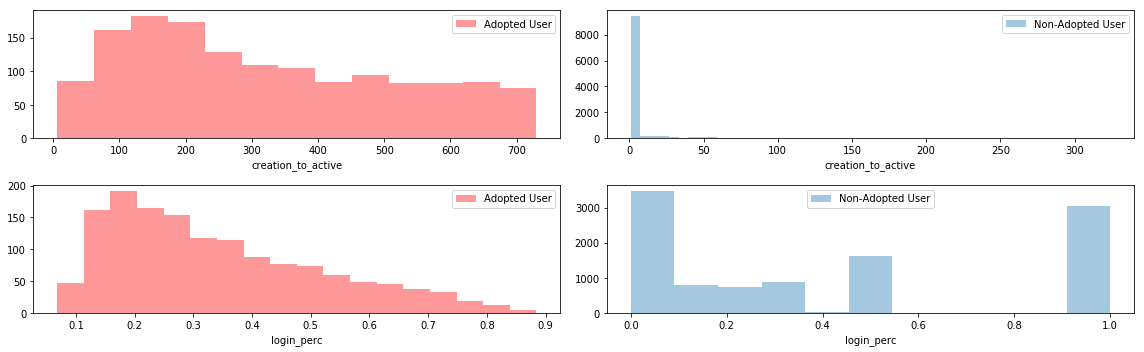

In [43]:
# Plot the two newly engineering columns
NEW_FEATURES = ['creation_to_active', 'login_perc']

fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(16,5))

for i in range(2):
    sns.distplot(target[NEW_FEATURES[i]], ax=ax[i][0], color='r', label='Adopted User', kde=False).legend()
    sns.distplot(non_target[NEW_FEATURES[i]], ax=ax[i][1], label='Non-Adopted User', kde=False).legend()
    
plt.tight_layout()

Let's move onto feature importance with random forest. First I need to perform preprocessing steps. I will do these manually with pd.get_dummies and StandardScaler

In [44]:
merged_users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 0 to 11999
Data columns (total 11 columns):
object_id                     12000 non-null int64
creation_source               12000 non-null object
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            12000 non-null int32
daily_visits                  12000 non-null float64
adopted_user                  12000 non-null int32
creation_to_active            12000 non-null int64
login_perc                    12000 non-null float64
email_domain                  12000 non-null object
dtypes: float64(2), int32(2), int64(5), object(2)
memory usage: 1.3+ MB


In [45]:
# Split the data into X(variables) and y(target)
X = merged_users.drop(['object_id', 'adopted_user'], axis=1)
y = merged_users['adopted_user']

In [46]:
# Define the numerical columns
NUMERICAL = ['daily_visits', 'creation_to_active', 'login_perc']

# Define the categorical columns
CATEGORICAL = [col for col in merged_users.columns if col not in NUMERICAL]

# Remove object_id and adopted_user column from the categorical list
CATEGORICAL.remove('object_id')
CATEGORICAL.remove('adopted_user')

In [47]:
# Transform the numerical columns with the StandardScaler
numerical_data = StandardScaler().fit_transform(X[NUMERICAL])

# Create the numerical dataframe
numerical_df = pd.DataFrame(numerical_data, columns=NUMERICAL)

# Copy the categorical columns to another dataframe
categorical_df = X[CATEGORICAL].copy()

# Transform the categorical columns in pd.get_dummies
for col in CATEGORICAL:
    categorical_dummies = pd.get_dummies(categorical_df[col]).rename(columns=lambda x: col+str(x))
    categorical_df = categorical_df.join(categorical_dummies)
    del categorical_df[col]

In [48]:
numerical_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 3 columns):
daily_visits          12000 non-null float64
creation_to_active    12000 non-null float64
login_perc            12000 non-null float64
dtypes: float64(3)
memory usage: 281.3 KB


In [49]:
categorical_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 0 to 11999
Columns: 4175 entries, creation_sourceGUEST_INVITE to email_domainzwmry.com
dtypes: uint8(4175)
memory usage: 48.2 MB


In [50]:
# Merge the two dataframes
merged_df = pd.concat([numerical_df, categorical_df], axis=1)

In [51]:
# Fit the converted data to the RandomForestClassifier()
rf = RandomForestClassifier().fit(merged_df, y)

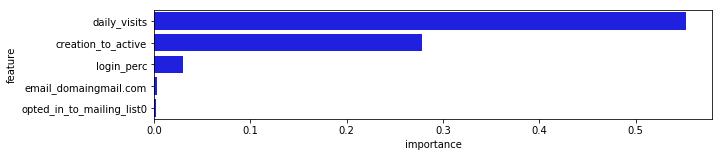

In [52]:
# Extract the feature importances and zip it with the columns into a dataframe
importances = rf.feature_importances_
features = pd.DataFrame({'feature': merged_df.columns, 'importance': importances})
features.sort_values(by='importance', ascending=False, inplace=True)

# Display a horizontal barplot with the first 5 feature importances
plt.figure(figsize=(10,2))
sns.barplot(x=features['importance'][:5], y=features['feature'][:5], color='blue', orient='h')

In [53]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(merged_df, y, test_size=0.2)

In [54]:
# Create the Pipeline with LogisticRegression
rf = RandomForestClassifier(n_estimators=100)

# Fit the Pipeline with the training data
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [55]:
# Assign the predictions to variables
predicted_train_values = rf.predict_proba(X_train)[:, -1]
predicted_test_values = rf.predict_proba(X_test)[:, -1]

# Print the scores
print (roc_auc_score(y_test, predicted_test_values))

0.9978774895180271


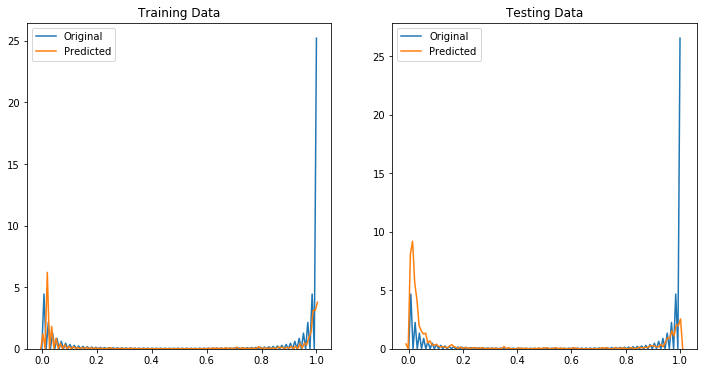

In [56]:
# Define the figure
fig, ax = plt.subplots(ncols=2, figsize=(12,6))

# Plot the training data
sns.kdeplot(y_train, ax=ax[0], label='Original').set_title('Training Data')
sns.kdeplot(predicted_train_values, ax=ax[0], label='Predicted')

# Plot the test data
sns.kdeplot(y_test, ax=ax[1], label='Original').set_title('Testing Data')
sns.kdeplot(predicted_test_values, ax=ax[1], label='Predicted')